In [79]:
import numpy as np
import os, sys

from osgeo import gdal
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from keras.models import Model
from keras.layers import Input, concatenate, merge, UpSampling2D, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import matplotlib.pyplot as plt

In [2]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

In [3]:
raster_data_path = "images/tiles/tile_1000_4000.tif"
output_fname = ".classification.tif"
shapefile_path = "./shape_files/splits/"
# validation_data_path = "data/train/"

In [4]:
raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []

In [5]:
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape

In [6]:
print(rows, cols, n_bands)

1000 1000 11


In [8]:
files = [f for f in os.listdir(shapefile_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(shapefile_path, f)
              for f in files if f.endswith('.shp')]

In [9]:
data_source = gdal.OpenEx(shapefile_path, gdal.OF_VECTOR)
layer = data_source.GetLayer(0)

In [10]:
labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)

In [12]:
is_train = np.nonzero(labeled_pixels)

In [13]:
print(np.shape(labeled_pixels), np.shape(bands_data))

(1000, 1000) (1000, 1000, 11)


In [14]:
xtrain = np.delete(bands_data, 10, 2)

In [15]:
xtrain = np.delete(xtrain, 9, 2)

In [18]:
n_samples = rows*cols
flat_pixels = xtrain.reshape((n_samples, 9))

In [19]:
ytrain = labeled_pixels.reshape((n_samples, 1))

In [56]:
print(np.shape(xtrain))

(1000, 1000, 9)


In [21]:
from scipy.stats import itemfreq
print(itemfreq(ytrain).astype(int))

[[     0 614037]
 [     1 274063]
 [     2  35738]
 [     3  76151]
 [     5     11]]


In [23]:
ytrain[ytrain == 5 ] = 0

In [24]:
print(itemfreq(ytrain).astype(int))

[[     0 614048]
 [     1 274063]
 [     2  35738]
 [     3  76151]]


### Preprocessing

In [25]:
mms = StandardScaler()
xtrain_scaled = mms.fit_transform(flat_pixels)

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


 ## Random forest classification

In [26]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(xtrain_scaled, ytrain)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
result = classifier.predict(xtrain_scaled)

In [28]:
print(np.shape(result))

(1000000,)


In [29]:
classification = result.reshape((rows, cols))

In [30]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

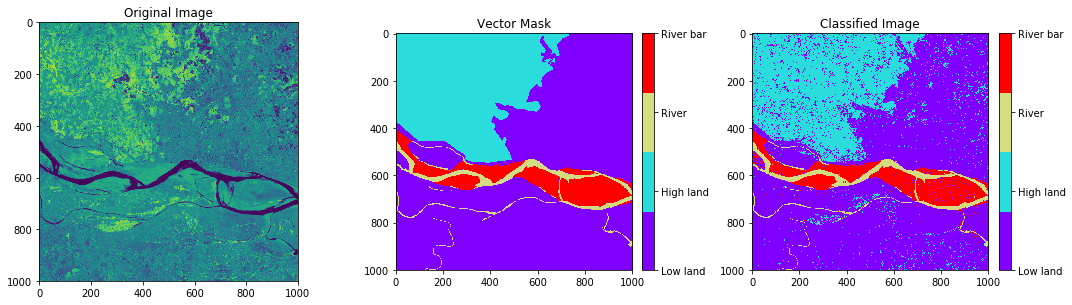

In [51]:
f = plt.figure(figsize=(15, 10))
labels = ['Low land', 'High land', 'River', 'River bar']
plt.subplot(1, 3, 1)
plt.imshow(bands_data[:, :, 6])
plt.title('Original Image')

plt.subplot(1, 3, 2)
im = plt.imshow(labeled_pixels.astype(np.float64), cmap = discrete_cmap(4, 'rainbow'))
plt.title('Vector Mask')
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(labels)

plt.subplot(1, 3, 3)
im = plt.imshow(classification, cmap = discrete_cmap(4, 'rainbow'))
plt.title('Classified Image')
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()

###  Testing-1 : tiles: 5000/5000

In [103]:
test_data_path = "images/tiles/tile_1000_2000.tif"
test_raster = gdal.Open(test_data_path, gdal.GA_ReadOnly)
geo_transform = test_raster.GetGeoTransform()
proj = test_raster.GetProjectionRef()
test_bands_data = []

In [104]:
for b in range(1, test_raster.RasterCount+1):
    band = test_raster.GetRasterBand(b)
    test_bands_data.append(band.ReadAsArray())

test_bands_data = np.dstack(test_bands_data)
test_rows, test_cols, test_n_bands = test_bands_data.shape

In [105]:
np.shape(test_bands_data)

(1000, 1000, 11)

In [106]:
xtest = np.delete(test_bands_data, 10, 2)
xtest = np.delete(xtest, 9, 2)

In [107]:
np.shape(xtest)

(1000, 1000, 9)

In [108]:
test_flat_pixels = xtest.reshape((n_samples, 9))
test_mms = StandardScaler()
xtest_scaled = test_mms.fit_transform(test_flat_pixels)

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [109]:
test_result = classifier.predict(xtest_scaled)
test_classification = test_result.reshape((rows, cols))

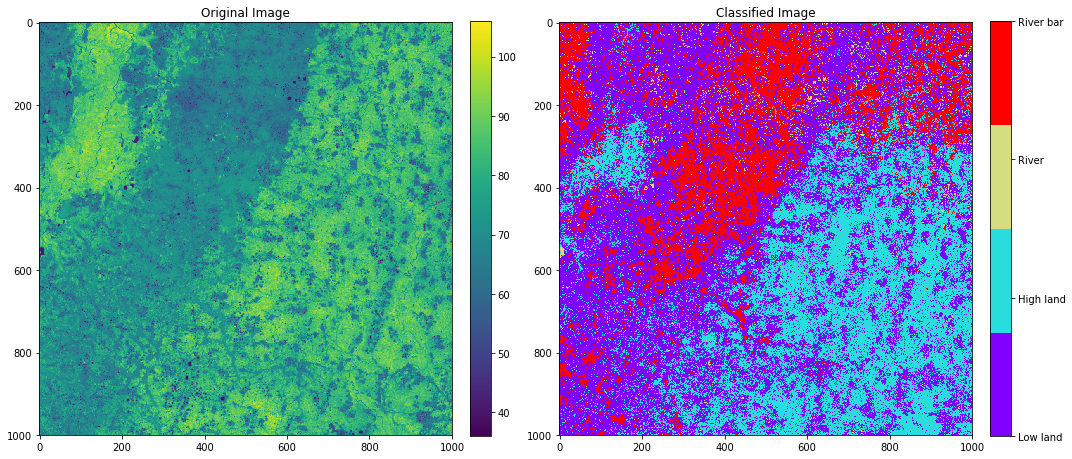

In [110]:
f = plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
im = plt.imshow(test_bands_data[:, :, 6])
plt.title('Original Image')
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.subplot(1, 2, 2)
im = plt.imshow(test_classification, cmap=discrete_cmap(4, 'rainbow'))
plt.title('Classified Image')
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(labels)
plt.tight_layout()
plt.show()

## Unet - Fully convolutional neural Network

In [64]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [86]:
def get_unet():
    inputs = Input((rows, cols, 9))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

#     up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
#     conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

#     up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
#     conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

#     up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
#     conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [85]:
model = get_unet()

ValueError: `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 186, 186, 256), (None, 125, 125, 256)]

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000, 1000, 9)     0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 1000, 1000, 32)    2624      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 1000, 1000, 32)    9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 500, 500, 32)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 500, 500, 64)      18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 500, 500, 64)      36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 250, 250, 64)      0         
__________